Notes:
* NER system classifying entity or not(without classes) O, B, I
* Joining text, for each pair of entities create new training example adding [E1][E2] tags
* Classifying relations(or absence)

In [ ]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Notebook is using: {device}')

Notebook is using: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.6 MB/s eta 0:00:00


In [ ]:
%pip install --upgrade transformers datasets accelerate deepspeed
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.9/809.9 kB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 19.0 MB/s eta 0:

In [ ]:
from tqdm.autonotebook import tqdm
from collections import Counter
import nltk
import gensim.downloader
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
from transformers import (pipeline,
        AutoModelForTokenClassification, AutoTokenizer,
        BertForTokenClassification, BertTokenizer)

[2023-07-10 14:14:52,473] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [ ]:
from torch.optim import AdamW
from IPython.display import clear_output
from transformers import get_scheduler

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=3d8250bd7e1fdcb40440cc069053b31dafdc364e8700e4aa28315f7b847bb20b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report, f1_score

In [ ]:
from collections import defaultdict
from collections import Counter
from itertools import combinations
import re
from sklearn.metrics import f1_score

## Functions

#### visualize

In [ ]:
def counter_plot(counter):
  """
  Draw horizontal barplot with count labels
  """
  ax = sns.barplot(x = list(counter.values()),
                 y = list(counter.keys()))
  plt.yticks(size=12)
  plt.xticks(size=12)
  for i in ax.containers:
      ax.bar_label(i,size=12)

#### dataset

In [ ]:
class PadSequence:
    def __init__(self, padded_columns, device='cuda'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        """
        Padds a batch to a max lenght in the batch
        """
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)

        for key, val in padded_batch.items():
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch

#### RE preprocessing

In [ ]:
def get_rel_type(x, e1, e2):
  """
  Searches the relation type in ['relationMentions'] for given entity mentions
  """
  for rel in x['relationMentions']:
    if (rel['em1Text'] == e1 and rel['em2Text'] == e2) or (rel['em1Text'] == e2 and rel['em2Text'] == e1):
      return rel['label']
  return 'none'

In [ ]:
def get_relations_dataset(train):
    """
    Returns dataset with tagged([E1], [E2]) entities in sentText
    and a label corresponding to a relation type
    """
    rows = {'sentText': [], 'label' : []}
    for x in tqdm(train):
      for entity1, entity2 in combinations(x['entityMentions'], 2):
        sentText = x['sentText']
        sentText = re.sub(fr"({entity1['text']})", r'[E1] \1 [E1]', sentText, 1)
        sentText = re.sub(fr"({entity2['text']})", r'[E2] \1 [E2]', sentText, 1)
        label = get_rel_type(x, entity1['text'], entity2['text'])
        rows['sentText'].append(sentText)
        rows['label'].append(label)
    return datasets.Dataset.from_dict(rows)

In [ ]:
def tokenizeRE(example):
    """
    Tokenizing relation dataset
    """
    res = tokenizer(example['sentText'])
    res['labels'] = labels_dict[example['label']]
    return res

#### BERT for relation extraction

In [ ]:
class FewShotBertForRE(nn.Module):
  def __init__(self, bert, special_tokens, num_classes):
      super().__init__()
      self.bert = bert.distilbert
      self.st = special_tokens
      embedding_dim = bert.config.to_dict()['dim']
      self.out = nn.Linear(embedding_dim, num_classes)
      self.bn = nn.BatchNorm1d(embedding_dim)

  def forward(self, batch):
    """
    Extracts word embeddings from bert model, performs max pooling
    on [CLS], [E1], [E2] tokens and passes result to a classifier
    Returns logits
    """
    embedded1 = self.bert(input_ids=batch["input_ids_1"].to(device),
                         #token_type_ids=batch["token_type_ids_1"].to(device),
                         attention_mask=batch["attention_mask_1"].to(device),
                         return_dict=True)['last_hidden_state']
    embedded2 = self.bert(input_ids=batch["input_ids_2"].to(device),
                         #token_type_ids=batch["token_type_ids_2"].to(device),
                         attention_mask=batch["attention_mask_2"].to(device),
                         return_dict=True)['last_hidden_state']

    mask1 = (batch["input_ids_1"] == special_tokens['[CLS]']) | (batch["input_ids_1"] == special_tokens['[E1]']) | (batch["input_ids_1"] == special_tokens['[E2]'])
    mask2 = (batch["input_ids_2"] == special_tokens['[CLS]']) | (batch["input_ids_2"] == special_tokens['[E1]']) | (batch["input_ids_2"] == special_tokens['[E2]'])

    temp1 = torch.max(torch.mul(embedded1, mask1.unsqueeze(2)), dim=1).values
    temp2 = torch.max(torch.mul(embedded2, mask2.unsqueeze(2)), dim=1).values
    output = self.out(self.bn((temp1 - temp2).pow(2)))
    return output.reshape(len(batch['input_ids_1']))




In [ ]:
def calculate_val_loss(model, val_loader, criterion, device=device):
    """
    Calculates per-batch loss and then averaging the result
    Returns averaged loss
    """
    loss_list = []
    for _, batch in enumerate(tqdm(val_loader)):
        with torch.no_grad():
            predicted = model(batch)
            batch_loss = criterion(predicted, torch.Tensor(batch['labels']).to(device).long())
            loss_list.append(batch_loss.item())
    loss = np.mean(loss_list)
    return loss

In [ ]:
def train_RE_model(model,
                   train_loader,
                   val_loader,
                   calculate_val_loss,
                   criterion,
                   optimizer,
                   scheduler=None,
                   *args):
    """
    Training RE pytorch model
    """
    train_history = []
    dev_history = []
    count = 0
    for epoch in range(EPOCH):
        print(f"epoch: {epoch}")
        model.train()
        for i, batch in enumerate(tqdm(train_loader)):
            count += 1
            pred = model(batch, *args)
            loss = criterion(pred, torch.Tensor(batch['labels']).to(device).long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_history.append((count, loss.item()))
            if count % 100 == 0:
                clear_output(True)
                plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
                if len(dev_history):
                    plt.plot(*zip(*dev_history), color='red', label='dev_loss')
                plt.legend(); plt.grid(); plt.show()
            if count % 300 == 0:
                print("Scoring dev...")
                dev_history.append((count, calculate_val_loss(model, val_loader, criterion)))
                print('#%i Dev loss: %.3f' % dev_history[-1])
        scheduler.step()
    return dev_history[-1]

## Load data

In [ ]:
train = datasets.load_dataset("json", data_files='train.json')['train']
valid = datasets.load_dataset("json", data_files='valid.json')['train']
test = datasets.load_dataset("json", data_files='test.json')['train']

## Look at the data

In [ ]:
label_counter = Counter()
entity_counter = Counter()
num_relations_counter = []
for sent in train:
  num_relations_counter.append(len(sent['relationMentions']))
  for relation in sent['relationMentions']:
    label_counter[relation['label']] += 1
  for entity in sent['entityMentions']:
    entity_counter[entity['label']] +=1

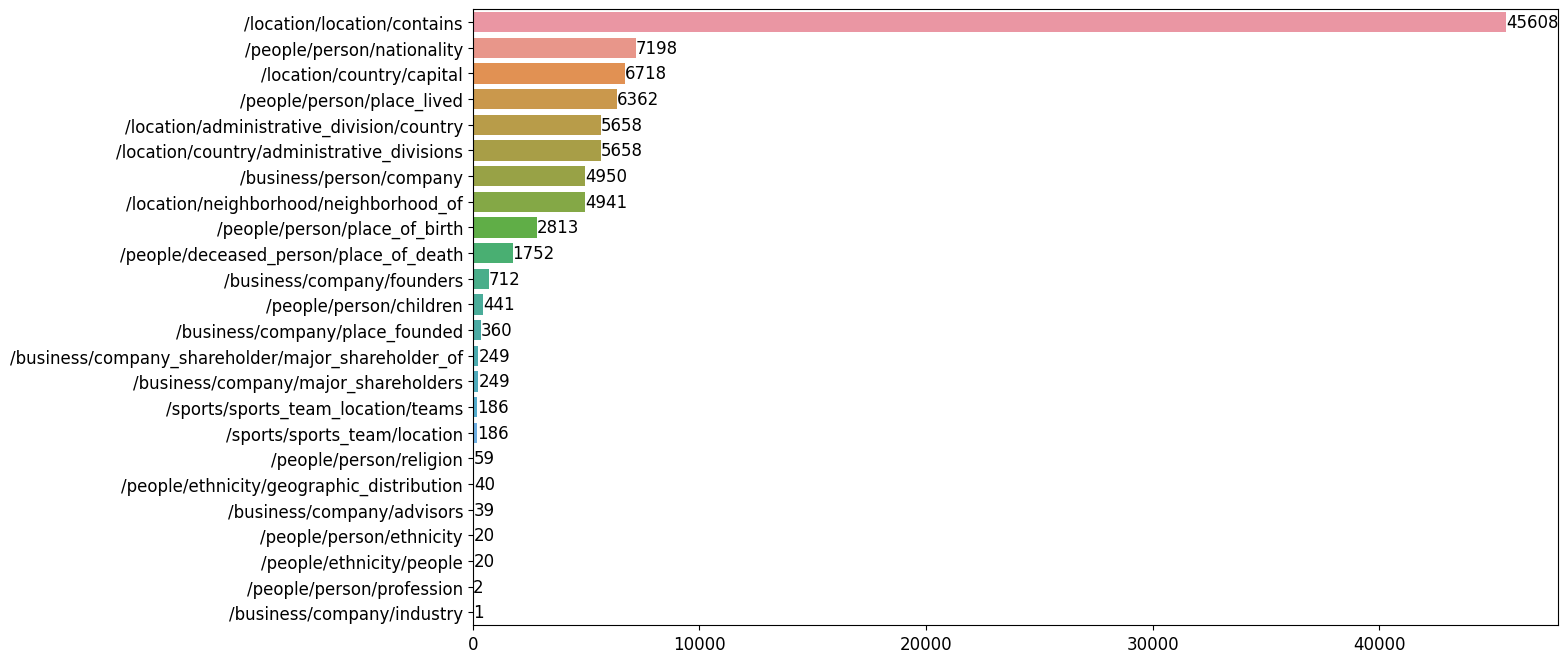

In [ ]:
plt.figure(figsize=(14, 8))
counter_plot({k: v for k, v in sorted(label_counter.items(), key=lambda item: -item[1])})

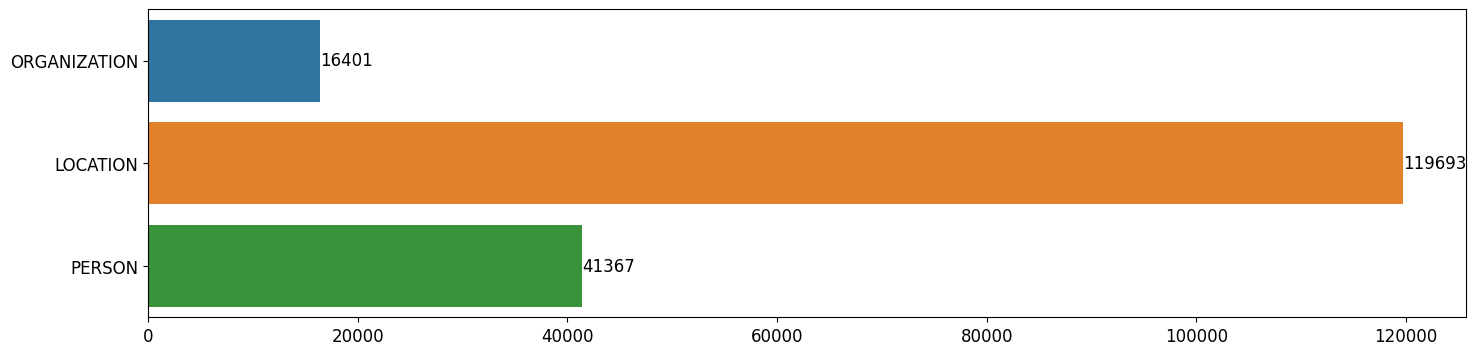

In [ ]:
plt.figure(figsize=(17, 4))
counter_plot(entity_counter)

## relation extraction preprocessing and training





####model

In [ ]:
model_name = 'distilbert-base-uncased'
rel_model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/dist_pretrained'
                                                            )

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_tokens(['[E1]', '[E2]'], special_tokens=True)

In [ ]:
special_tokens = {
    '[CLS]' : tokenizer('[CLS]')['input_ids'][1],
    '[E1]' : tokenizer('[E1]')['input_ids'][1],
    '[E2]' : tokenizer('[E2]')['input_ids'][1]
}
rel_model.resize_token_embeddings(len(tokenizer))

Embedding(30524, 768)

In [ ]:
rel_bert = FewShotBertForRE(rel_model, special_tokens, 1)
rel_bert.to(device)
None

#### preprocessing

In [ ]:
ds_train = get_relations_dataset(train)
ds_valid = get_relations_dataset(valid)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
labels_list = list(label_counter.keys()) + ['none']
labels_dict = dict(zip(labels_list, list(range(len(labels_list)))))

In [ ]:
ds_train = ds_train.map(tokenizeRE)
ds_valid = ds_valid.map(tokenizeRE)

Map:   0%|          | 0/22428 [00:00<?, ? examples/s]

In [ ]:
ds_train.set_format(type='torch', columns=['input_ids', 'attention_mask'], output_all_columns=True)
ds_valid.set_format(type='torch', columns=['input_ids', 'attention_mask'], output_all_columns=True)

#### training

In [ ]:
train_dataloader = torch.utils.data.DataLoader(ds_train,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=PadSequence(['input_ids',
                                                                       'token_type_ids',
                                                                       'attention_mask',
                                                                       ]))
val_dataloader = torch.utils.data.DataLoader(ds_valid,
                                             batch_size=BATCH_SIZE,
                                             collate_fn=PadSequence([ 'input_ids',
                                                                      'token_type_ids',
                                                                      'attention_mask',
                                                                      ]))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rel_bert.parameters(), lr=1e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

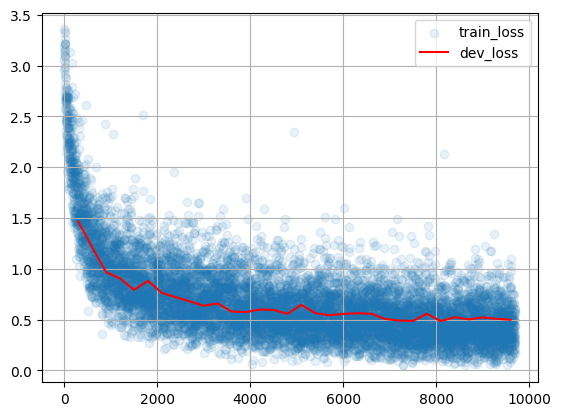

(9600, 0.4980679865839617)

In [ ]:
train_RE_model(rel_bert,
               train_dataloader,
               val_dataloader,
               calculate_val_loss,
               criterion,
               optimizer,
               scheduler)

In [ ]:
torch.save(rel_bert.state_dict(), '/content/drive/MyDrive/rel_model2')

#### evaluation

In [ ]:
rel_bert = BertForRE(rel_model, special_tokens, 25)
rel_bert.load_state_dict(torch.load('/content/drive/MyDrive/rel_model2'))
rel_bert.to(device)

In [ ]:
predicted_labels = []
for batch in tqdm(val_dataloader):
    temp = rel_bert(batch)
    labels = torch.argmax(temp, dim=1)
    predicted_labels.extend(labels.tolist())

  0%|          | 0/686 [00:00<?, ?it/s]

In [ ]:
labels = ds_valid['labels']

In [ ]:
f1_score(labels, predicted_labels, average='micro')

#### pretraining

In [ ]:
def tokenize_mlm(example):
    res = tokenizer(example['sentText'])
    return res

In [ ]:
model = transformers.DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
train_mlm = train.map(tokenize_mlm)
valid_mlm = valid.map(tokenize_mlm)

In [ ]:
model.to(device)
None

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)
training_args = TrainingArguments(
	output_dir = 'test_trainer_log',
	per_device_train_batch_size = 32,
	num_train_epochs = 1,
  evaluation_strategy = 'steps',
  eval_steps = 300,
  logging_steps = 300,
	report_to='none')

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_mlm.remove_columns(['sentText', 'articleId', 'relationMentions', 'entityMentions', 'sentId']),
    eval_dataset = valid_mlm.remove_columns(['sentText', 'articleId', 'relationMentions', 'entityMentions', 'sentId']),
)

In [ ]:
trainer.train()

In [ ]:
# model.save_pretrained('/content/drive/MyDrive/dist_pretrained')

#### few shot training

In [ ]:
few_shot_train = datasets.load_dataset("json", data_files='fs_d_train.json')['train']
few_shot_valid = datasets.load_dataset("json", data_files='fs_d_valid.json')['train']

In [ ]:
few_shot_train.set_format(type='torch', columns=
                          ['input_ids_1',
                            'attention_mask_1',
                            'input_ids_2',
                            'attention_mask_2',
                            ],
                           output_all_columns=True)
few_shot_valid.set_format(type='torch', columns=
                          ['input_ids_1',
                            'attention_mask_1',
                            'input_ids_2',
                            'attention_mask_2',
                            ],
                           output_all_columns=True)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(few_shot_train,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=PadSequence(['input_ids_1',
                                                                       'attention_mask_1',
                                                                       'input_ids_2',
                                                                       'attention_mask_2',
                                                                       ]))
val_dataloader = torch.utils.data.DataLoader(few_shot_valid,
                                             batch_size=BATCH_SIZE,
                                             collate_fn=PadSequence([ 'input_ids_1',
                                                                       'attention_mask_1',
                                                                       'input_ids_2',
                                                                       'attention_mask_2',
                                                                      ]))

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(rel_bert.parameters(), lr=2e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [ ]:
train_fsRE_model(rel_bert,
               train_dataloader,
               val_dataloader,
               calculate_binary_val_loss,
               criterion,
               optimizer,
               scheduler)

In [ ]:
def calculate_binary_val_loss(model, val_loader, criterion, device=device):
    """
    Calculates per-batch loss and then averaging the result
    Returns averaged loss
    """
    loss_list = []
    for _, batch in enumerate(tqdm(val_loader)):
        with torch.no_grad():
            predicted = model(batch)
            batch_loss = criterion(predicted, torch.Tensor(batch['label']).to(device))
            loss_list.append(batch_loss.item())
    loss = np.mean(loss_list)
    return loss

In [ ]:
# torch.save(rel_bert.state_dict(), '/content/drive/MyDrive/rel_model_few_shot_dist1')

In [ ]:
# few_shot_train.to_json('fs_train.json')
# few_shot_valid.to_json('fs_valid.json')

In [ ]:
rel_bert = FewShotBertForRE(rel_model, special_tokens, 1)
rel_bert.load_state_dict(torch.load('/content/drive/MyDrive/data/rel_model_few_shot'))
rel_bert.to(device)

In [ ]:
val_dataloader = torch.utils.data.DataLoader(few_shot_valid,
                                             batch_size=BATCH_SIZE,
                                             collate_fn=PadSequence([ 'input_ids_1',
                                                                       #'token_type_ids_1',
                                                                       'attention_mask_1',
                                                                       'input_ids_2',
                                                                       #'token_type_ids_2',
                                                                       'attention_mask_2',
                                                                      ]))

In [ ]:
predicted_labels = []
for batch in tqdm(val_dataloader):
    temp = rel_bert(batch)
    labels = temp > 0.5
    predicted_labels.extend(labels.tolist())

  0%|          | 0/1402 [00:00<?, ?it/s]

In [ ]:
labels = few_shot_valid['label']

In [ ]:
f1_score(labels, predicted_labels)

0.8605231537110639